<a href="https://colab.research.google.com/github/marymuench/Gun-Violence-Before-and-After-the-Parkland-Shooting/blob/main/MaryMuench_Data_Wrangling_Mod_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Wrangling Module Assignment 2
CW: Gun Violence

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statistics import mean
import matplotlib.patches as mpatches

**Question:** How did gun violence change before and after the Parkland shooting?

On February 14, 2018, a gunman opened fire on Marjory Stoneman Douglas High School in Parkland, Florida, killing 17 people and injuring 17 others. This tragic event, titled 'the Parkland shooting' for the remainder of this report, was a turning point in American history, marking the deadliest school schooting in the United States. While this school shooting was unfortunately far from the first deadly event in American schools, it sparked many debates and protests about gun control and the role of guns and the Second Amendment in our society. This report aims to analyze gun violence data from the months preceding and following the Parkland shooting to understand if this particularly violent event had any bearing on past or future incidents of gun violence. 

Please note: this topic contains a lot of information and would be very interesting to investigate at a higher, more extensive level. Due to time constraints and the parameters of this assignment, this question will only be investigated to a limited extent. 

# Read in Data

Because of the way the gun violence data is structured, the files for each month must be read in separately and then concatenated. The files for January 2018, February 2018, and March 2018 will be read in into separate Pandas dataframes. Unfortunately, the master GitHub repository containing all gun violence data lacks files for the months of 2018 following March, so only these three months will be analyzed. 

In [ ]:
df0118 = pd.read_csv('https://raw.githubusercontent.com/jamesqo/gun-violence-data/master/intermediate/stage2.01.2018.csv')

In [ ]:
df0218 = pd.read_csv('https://raw.githubusercontent.com/jamesqo/gun-violence-data/master/intermediate/stage2.02.2018.csv')


In [ ]:
# After some searching in the data, it was found that the Parkland Shooting is found
# at index 2912. 
df0218.iloc[2912]

incident_id                                                              1049217
date                                                                  2018-02-14
state                                                                    Florida
city_or_county                                          Pompano Beach (Parkland)
address                                                      5901 Pine Island Rd
n_killed                                                                      17
n_injured                                                                     17
incident_url                   http://www.gunviolencearchive.org/incident/104...
source_url                     http://www.orlandosentinel.com/news/fl-florida...
incident_url_fields_missing                                                False
congressional_district                                                      22.0
gun_stolen                                          0::Not-stolen||1::Not-stolen
gun_type                    

I am going to drop the entry for the Parkland Shooting (row #2912). This will make the visualizations easier to digest due to the extremities of this event.

In [ ]:
df0218 = df0218.drop(2912, axis=0)

In [ ]:
df0318 = pd.read_csv('https://raw.githubusercontent.com/jamesqo/gun-violence-data/master/intermediate/stage2.03.2018.csv')

In [ ]:
full_gv = pd.concat([df0118,df0218,df0318]) 

# Data Cleaning
Check the packaging, check the top and bottom, check the "n"s, reshape into a cleaner format, handle missing data, and filter/relabel bad data

**Check the packaging**

In [ ]:
full_gv.shape

(13801, 29)

This means there are 13801 incidents of gun violence between January 1, 2018 and March 31, 2018, not including the Parkland shooting. The dataframe contains 29 columns of information. We know from the README file of the GitHub Repo that these columns are incident ID, date, state, city/county, address, number killed, number injured, a link to details of the incident, a link to a news story about the incident, a column containing false values about if urls are missing, the congressional district, a dictionary with information about if guns involved were stolen, a dictionary containing information about the types of guns involved, characteristics about the incident, latitude, location description, longitude, number of funs involved, notes, a number of dictionaries containing information about the participants (namely, age, age group, gender, name, relationships, status, type), sources, state house district, and state senate district. 

Clearly, this dataframe contains a lot of different information about the incident. Many of the columns are superflouous to the question being investigated, and many contain unknown or missing values that muddle the dataset. 

The column titles appear to be well-named, so I will not change the names of any of them.

First, I am going to remove unncessary columns, such as some of the urls, latitude, longitude, notes, congressional districts, etc. These columns contain interesting information, but I have decided to drop them because I am only interested in specifics of certain incidents and many of them contain unknown values. I am also not at this time investigating legislature related to gun violence as a result of the Parkland shooting, so I decided to drop this data, however, this would be a very interesting further investigation of this topic. 

In [ ]:
full_gv = full_gv.drop(columns=['address', 'incident_url', 'source_url', 'incident_url_fields_missing', 'congressional_district', 
                           'incident_characteristics', 'latitude','longitude','notes','sources', 'state_house_district', 'state_senate_district', 'participant_relationship'])

full_gv

,incident_id,date,state,city_or_county,n_killed,n_injured,gun_stolen,gun_type,location_description,n_guns_involved,participant_age,participant_age_group,participant_gender,participant_name,participant_status,participant_type
0,1024565,2018-01-10,California,El Cajon,0,0,0::Unknown,0::Unknown,Granite Hills High School,1.0,NaN,0::Adult 18+,0::Male,NaN,"0::Unharmed, Arrested",0::Subject-Suspect
1,1025324,2018-01-10,Ohio,Toledo,0,1,0::Unknown,0::Unknown,NaN,1.0,NaN,0::Adult 18+,0::Male,0::Richard Tucker,0::Injured,0::Victim
2,1025382,2018-01-10,Kentucky,Louisville,0,0,0::Unknown,0::Unknown,NaN,1.0,0::23||1::23||2::23||3::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male,0::Jacob Holman||1::Jahi C. Hall||2::Colton D....,"0::Unharmed, Arrested||1::Unharmed, Arrested||...",0::Subject-Suspect||1::Subject-Suspect||2::Sub...
3,1025397,2018-01-10,Massachusetts,New Bedford,0,0,0::Unknown,0::Unknown,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1059686,2018-01-10,Maine,Belfast,0,0,0::Unknown,0::Rifle,NaN,1.0,0::57,0::Adult 18+,0::Female,0::Laurie Allen,"0::Unharmed, Arrested",0::Subject-Suspect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,1065829,2018-03-09,Florida,Lehigh Acres,0,0,0::Unknown,0::Unknown,NaN,1.0,0::20,0::Adult 18+,0::Male,0::Montrel Johnson,"0::Unharmed, Arrested",0::Subject-Suspect
4748,1066571,2018-03-09,Maryland,Baltimore,1,0,0::Unknown,0::Unknown,NaN,1.0,0::30,0::Adult 18+,0::Male,0::Ronald Preston,0::Killed,0::Victim
4749,1066492,2018-03-09,Illinois,Chicago,0,1,0::Unknown,0::Unknown,NaN,1.0,0::17,0::Teen 12-17,0::Male||1::Male,NaN,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect
4750,1065756,2018-03-09,Texas,Aledo,2,0,0::Unknown,0::Unknown,Temptations Cabaret,1.0,0::32||2::24,0::Adult 18+||1::Adult 18+||2::Adult 18+,0::Male||2::Male,0::Julian Marin||2::Treveon Wilson,"0::Killed||1::Killed||2::Unharmed, Arrested",0::Victim||1::Victim||2::Subject-Suspect


Despite superfluous columns being removed, this dataframe still has many structural issues that impact the interpretability and flow of the dataframe. For instance, many columns contain dictionaries holding relationships of an ID to more information. This is a design flaw and makes the data difficult to read and parse through. To improve this issue, I attempted to put the information about participants into a new dataframe with a stacked index. View the write up for a holistic explanation of the challenges regarding this problem.

In [ ]:
participants = [full_gv['incident_id'], full_gv['participant_type'], full_gv['participant_age'],full_gv['participant_age_group'],
                          full_gv['participant_gender'], full_gv['participant_status'], 
                          ]
p_df = pd.concat(participants, axis=1)
p_df

,incident_id,participant_type,participant_age,participant_age_group,participant_gender,participant_status
0,1024565,0::Subject-Suspect,NaN,0::Adult 18+,0::Male,"0::Unharmed, Arrested"
1,1025324,0::Victim,NaN,0::Adult 18+,0::Male,0::Injured
2,1025382,0::Subject-Suspect||1::Subject-Suspect||2::Sub...,0::23||1::23||2::23||3::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male,"0::Unharmed, Arrested||1::Unharmed, Arrested||..."
3,1025397,NaN,NaN,NaN,NaN,NaN
4,1059686,0::Subject-Suspect,0::57,0::Adult 18+,0::Female,"0::Unharmed, Arrested"
...,...,...,...,...,...,...
4747,1065829,0::Subject-Suspect,0::20,0::Adult 18+,0::Male,"0::Unharmed, Arrested"
4748,1066571,0::Victim,0::30,0::Adult 18+,0::Male,0::Killed
4749,1066492,0::Victim||1::Subject-Suspect,0::17,0::Teen 12-17,0::Male||1::Male,0::Injured||1::Unharmed
4750,1065756,0::Victim||1::Victim||2::Subject-Suspect,0::32||2::24,0::Adult 18+||1::Adult 18+||2::Adult 18+,0::Male||2::Male,"0::Killed||1::Killed||2::Unharmed, Arrested"


In [ ]:
p = p_df.iat[2, 1]
p = p.split("||")
p

['0::Subject-Suspect',
 '1::Subject-Suspect',
 '2::Subject-Suspect',
 '3::Subject-Suspect']

In [ ]:
print(p[0][3:])

Subject-Suspect


In [ ]:
"""
def trim(word):
  return word[3:]


from numpy.core.numeric import NaN
iid = []
pid = []
age = []
age_g = []
status = []
p_type = []


row_index = 0
for i in range(13801):
  col_index = 0
  current_id = p_df.iat[row_index,0]

  # get full participant list- based on participant_type
  participants = p_df.iat[row_index, 1]
  
  if(np.isnan(participants)):
    iid.append(current_id)
    pid.append(NaN)
    age.append(NaN)
    age_g.append(NaN)
    status.append(NaN)
    p_type.append(NaN)


  else:
    p_list = participants.split("||")
    num_participants = len(p_list)

    temp_pid = 0
    for p in p_list:
      # copy incident id
      iid.append(current_id)

      # create pid
      pid.append(temp_pid)
      pid = pid + 1

      # append participant types
      p = trim(p)
      p_type.append(p)

    # now, append ages 
    p_age = p_df.iat[row_index, 2]
    if(np.isnan(p_age)):

    



  row_index = row_index + 1
  
""" 

'\ndef trim(word):\n  return word[3:]\n\n\nfrom numpy.core.numeric import NaN\niid = []\npid = []\nage = []\nage_g = []\nstatus = []\np_type = []\n\n\nrow_index = 0\nfor i in range(13801):\n  col_index = 0\n  current_id = p_df.iat[row_index,0]\n\n  # get full participant list- based on participant_type\n  participants = p_df.iat[row_index, 1]\n  \n  if(np.isnan(participants)):\n    iid.append(current_id)\n    pid.append(NaN)\n    age.append(NaN)\n    age_g.append(NaN)\n    status.append(NaN)\n    p_type.append(NaN)\n\n\n  else:\n    p_list = participants.split("||")\n    num_participants = len(p_list)\n\n    temp_pid = 0\n    for p in p_list:\n      # copy incident id\n      iid.append(current_id)\n\n      # create pid\n      pid.append(temp_pid)\n      pid = pid + 1\n\n      # append participant types\n      p = trim(p)\n      p_type.append(p)\n\n    # now, append ages \n    p_age = p_df.iat[row_index, 2]\n    if(np.isnan(p_age)):\n\n    \n\n\n\n  row_index = row_index + 1\n  \n'

In [ ]:
'''
participants_mi = p_df.set_index(['iid', 'pid'])
'''

"\nparticipants_mi = p_df.set_index(['iid', 'pid'])\n"

As discussed in the write up below, the scope of the investigation has now varied slightly due to the difficulties regarding the stored dictionaries. I am now going to drop more columns from the dataset in order to focus in on ones relevant to this investigation. 

In [ ]:
full_gv = full_gv.drop(columns=['city_or_county', 'gun_stolen', 'gun_type', 'location_description', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_name','participant_status', 'participant_type'])

Next, I am going to separate the dataframe into two separate dataframes: one containing incidents prior to the Parkland shooting, and one for incidents after. These will be named pre_gv and post_gv, respectively.

In [ ]:
pre_gv = full_gv[full_gv['date'] <= "2018-02-14"]
pre_gv

,incident_id,date,state,n_killed,n_injured,n_guns_involved
0,1024565,2018-01-10,California,0,0,1.0
1,1025324,2018-01-10,Ohio,0,1,1.0
2,1025382,2018-01-10,Kentucky,0,0,1.0
3,1025397,2018-01-10,Massachusetts,0,0,1.0
4,1059686,2018-01-10,Maine,0,0,1.0
...,...,...,...,...,...,...
4119,1042375,2018-02-02,Pennsylvania,0,1,1.0
4120,1042747,2018-02-02,Indiana,0,0,1.0
4121,1042168,2018-02-02,Montana,0,1,1.0
4122,1042228,2018-02-02,South Carolina,1,1,1.0


In [ ]:
post_gv = full_gv[full_gv['date'] > "2018-02-14"]
post_gv

,incident_id,date,state,n_killed,n_injured,n_guns_involved
0,1057705,2018-02-24,North Carolina,0,1,1.0
1,1056932,2018-02-24,Pennsylvania,0,1,1.0
2,1056938,2018-02-24,Texas,0,1,1.0
3,1056943,2018-02-24,Florida,0,1,1.0
4,1056924,2018-02-24,Minnesota,0,0,1.0
...,...,...,...,...,...,...
4747,1065829,2018-03-09,Florida,0,0,1.0
4748,1066571,2018-03-09,Maryland,1,0,1.0
4749,1066492,2018-03-09,Illinois,0,1,1.0
4750,1065756,2018-03-09,Texas,2,0,1.0


Now that these two dataframes are fairly clean and organized, we will check the null values, check the head and tails, and validate against an external data source, following the EDA.

 **Check the head and tails** of each df:

In [ ]:
pre_gv.head()

,incident_id,date,state,n_killed,n_injured,n_guns_involved
0,1024565,2018-01-10,California,0,0,1.0
1,1025324,2018-01-10,Ohio,0,1,1.0
2,1025382,2018-01-10,Kentucky,0,0,1.0
3,1025397,2018-01-10,Massachusetts,0,0,1.0
4,1059686,2018-01-10,Maine,0,0,1.0


In [ ]:
pre_gv.tail()

,incident_id,date,state,n_killed,n_injured,n_guns_involved
4119,1042375,2018-02-02,Pennsylvania,0,1,1.0
4120,1042747,2018-02-02,Indiana,0,0,1.0
4121,1042168,2018-02-02,Montana,0,1,1.0
4122,1042228,2018-02-02,South Carolina,1,1,1.0
4123,1041700,2018-02-02,Georgia,1,0,1.0


In [ ]:
post_gv.head()

,incident_id,date,state,n_killed,n_injured,n_guns_involved
0,1057705,2018-02-24,North Carolina,0,1,1.0
1,1056932,2018-02-24,Pennsylvania,0,1,1.0
2,1056938,2018-02-24,Texas,0,1,1.0
3,1056943,2018-02-24,Florida,0,1,1.0
4,1056924,2018-02-24,Minnesota,0,0,1.0


In [ ]:
post_gv.tail()

,incident_id,date,state,n_killed,n_injured,n_guns_involved
4747,1065829,2018-03-09,Florida,0,0,1.0
4748,1066571,2018-03-09,Maryland,1,0,1.0
4749,1066492,2018-03-09,Illinois,0,1,1.0
4750,1065756,2018-03-09,Texas,2,0,1.0
4751,1069938,2018-03-09,Maryland,0,0,1.0


**Check the n's again now that the data is cleaner**

In [ ]:
pre_gv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6880 entries, 0 to 4123
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   incident_id      6880 non-null   int64  
 1   date             6880 non-null   object 
 2   state            6880 non-null   object 
 3   n_killed         6880 non-null   int64  
 4   n_injured        6880 non-null   int64  
 5   n_guns_involved  6877 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 376.2+ KB


In [ ]:
pre_gv.value_counts

<bound method DataFrame.value_counts of       incident_id        date  ... n_injured  n_guns_involved
0         1024565  2018-01-10  ...         0              1.0
1         1025324  2018-01-10  ...         1              1.0
2         1025382  2018-01-10  ...         0              1.0
3         1025397  2018-01-10  ...         0              1.0
4         1059686  2018-01-10  ...         0              1.0
...           ...         ...  ...       ...              ...
4119      1042375  2018-02-02  ...         1              1.0
4120      1042747  2018-02-02  ...         0              1.0
4121      1042168  2018-02-02  ...         1              1.0
4122      1042228  2018-02-02  ...         1              1.0
4123      1041700  2018-02-02  ...         0              1.0

[6880 rows x 6 columns]>

In [ ]:
post_gv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6921 entries, 0 to 4751
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   incident_id      6921 non-null   int64  
 1   date             6921 non-null   object 
 2   state            6921 non-null   object 
 3   n_killed         6921 non-null   int64  
 4   n_injured        6921 non-null   int64  
 5   n_guns_involved  6915 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 378.5+ KB


In [ ]:
post_gv.value_counts

<bound method DataFrame.value_counts of       incident_id        date  ... n_injured  n_guns_involved
0         1057705  2018-02-24  ...         1              1.0
1         1056932  2018-02-24  ...         1              1.0
2         1056938  2018-02-24  ...         1              1.0
3         1056943  2018-02-24  ...         1              1.0
4         1056924  2018-02-24  ...         0              1.0
...           ...         ...  ...       ...              ...
4747      1065829  2018-03-09  ...         0              1.0
4748      1066571  2018-03-09  ...         0              1.0
4749      1066492  2018-03-09  ...         1              1.0
4750      1065756  2018-03-09  ...         0              1.0
4751      1069938  2018-03-09  ...         0              1.0

[6921 rows x 6 columns]>

This shows that there is a small number of NaN values for the number of guns involved. To address this, I will fill all of those NaN values with the mean number of guns utilized before and after the Parkland shooting.

In [ ]:
pre_gv.describe()

,incident_id,n_killed,n_injured,n_guns_involved
count,6.880000e+03,6880.000000,6880.000000,6877.000000
mean,1.035159e+06,0.272529,0.465988,1.275556
std,9.910237e+03,0.521386,0.673037,2.094024
min,1.018018e+06,0.000000,0.000000,1.000000
25%,1.026796e+06,0.000000,0.000000,1.000000
50%,1.035096e+06,0.000000,0.000000,1.000000
75%,1.042996e+06,0.000000,1.000000,1.000000
max,1.080973e+06,5.000000,14.000000,50.000000


In [ ]:
mean_pre = 1.27556
pre_gv.fillna(value=mean_pre, inplace=True)
pre_gv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6880 entries, 0 to 4123
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   incident_id      6880 non-null   int64  
 1   date             6880 non-null   object 
 2   state            6880 non-null   object 
 3   n_killed         6880 non-null   int64  
 4   n_injured        6880 non-null   int64  
 5   n_guns_involved  6880 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 376.2+ KB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
post_gv.describe()

,incident_id,n_killed,n_injured,n_guns_involved
count,6.921000e+03,6921.000000,6921.000000,6915.000000
mean,1.066886e+06,0.237104,0.425950,1.268402
std,9.330735e+03,0.500854,0.645605,1.871248
min,1.049863e+06,0.000000,0.000000,1.000000
25%,1.058627e+06,0.000000,0.000000,1.000000
50%,1.067134e+06,0.000000,0.000000,1.000000
75%,1.074957e+06,0.000000,1.000000,1.000000
max,1.083472e+06,5.000000,7.000000,48.000000


In [ ]:
mean_post = 1.2684
post_gv.fillna(value=mean_post, inplace=True)
post_gv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6921 entries, 0 to 4751
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   incident_id      6921 non-null   int64  
 1   date             6921 non-null   object 
 2   state            6921 non-null   object 
 3   n_killed         6921 non-null   int64  
 4   n_injured        6921 non-null   int64  
 5   n_guns_involved  6921 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 378.5+ KB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


**Validate against an external data source**


Although one month following the Parkland may not be enough time to fully understand the aftermath of the event on gun control, it is a limit of the dataset provided. However, according to Vox.com, there is indication that many states enacted new gun control laws quickly following the Parkland shooting: "According to the Giffords Law Center (which supports stricter gun laws), 26 states and Washington, DC, enacted a total of 67 new gun control laws this year[2018]  — more than triple the number of stricter gun laws enacted in 2017" (Lopez, 2018). Ideally, this would indicate a decrease in gun violence incidents, or the severity of gun violence incidents, following the Parkland shooting. 

Reference: 
Lopez, G. (2018, December 26). How the Parkland shooting changed America's gun debate. Retrieved from https://www.vox.com/2018/12/26/18145305/gun-control-violence-parkland-effect-2018

# Data Visualizations


Text(0.5, 0.98, 'Number Killed Per GW Incident Pre and Post Parkland')

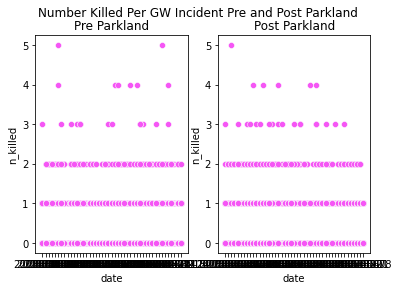

In [ ]:
fig, axs = plt.subplots(ncols=2)
sns.scatterplot(x='date', y='n_killed', data=pre_gv, ax=axs[0], color='#f556f5').set_title('Pre Parkland')
sns.scatterplot(x='date', y='n_killed', data=post_gv, ax=axs[1],color='#f556f5').set_title('Post Parkland')
fig.suptitle('Number Killed Per GW Incident Pre and Post Parkland')


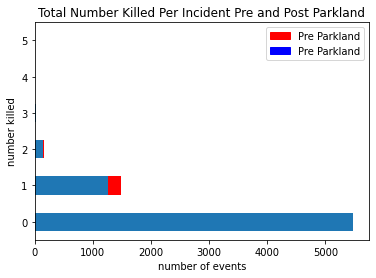

In [ ]:
# information about patches from https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html

pre_gv['n_killed'].value_counts().plot(kind='barh', color='r')
post_gv['n_killed'].value_counts().plot(kind='barh')
plt.xlabel('number of events')
plt.ylabel('number killed')
red_patch = mpatches.Patch(color='red', label='Pre Parkland')
blue_patch = mpatches.Patch(color='blue', label='Pre Parkland')
plt.legend(handles=[red_patch, blue_patch])
plt.title('Total Number Killed Per Incident Pre and Post Parkland')
plt.show()

Text(0.5, 0.98, 'Number Injured Per GW Incident Pre and Post Parkland')

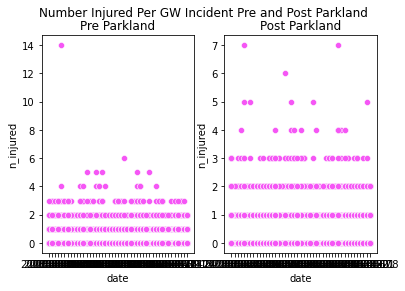

In [ ]:
fig, axs = plt.subplots(ncols=2)
sns.scatterplot(x='date', y='n_injured', data=pre_gv, ax=axs[0], color='#f556f5').set_title('Pre Parkland')
sns.scatterplot(x='date', y='n_injured', data=post_gv, ax=axs[1],color='#f556f5').set_title('Post Parkland')
fig.suptitle('Number Injured Per GW Incident Pre and Post Parkland')

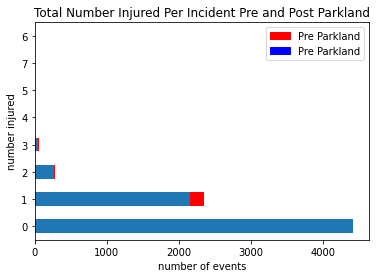

In [ ]:
pre_gv['n_injured'].value_counts().plot(kind='barh', color='r')
post_gv['n_injured'].value_counts().plot(kind='barh')
plt.xlabel('number of events')
plt.ylabel('number injured')
red_patch = mpatches.Patch(color='red', label='Pre Parkland')
blue_patch = mpatches.Patch(color='blue', label='Pre Parkland')
plt.legend(handles=[red_patch, blue_patch])
plt.title('Total Number Injured Per Incident Pre and Post Parkland')
plt.show()

Text(0.5, 0.98, 'Number of Guns Involved Per GW Incident Pre and Post Parkland')

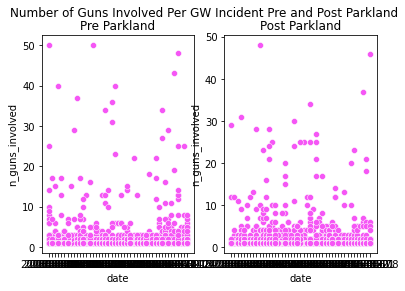

In [ ]:
fig, axs = plt.subplots(ncols=2)
sns.scatterplot(x='date', y='n_guns_involved', data=pre_gv, ax=axs[0], color='#f556f5').set_title('Pre Parkland')
sns.scatterplot(x='date', y='n_guns_involved', data=post_gv, ax=axs[1],color='#f556f5').set_title('Post Parkland')
fig.suptitle('Number of Guns Involved Per GW Incident Pre and Post Parkland')

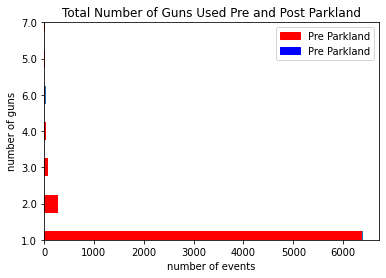

In [ ]:
post_gv['n_guns_involved'].value_counts().plot(kind='barh')
pre_gv['n_guns_involved'].value_counts().plot(kind='barh', color='r')

plt.xlabel('number of events')
plt.ylabel('number of guns')
red_patch = mpatches.Patch(color='red', label='Pre Parkland')
blue_patch = mpatches.Patch(color='blue', label='Pre Parkland')
plt.legend(handles=[red_patch, blue_patch])
plt.ylim([0,6])
plt.title('Total Number of Guns Used Pre and Post Parkland')
plt.show()

#Statistical Methods

For each separate dependent variable, I am going to run t-tests to see if there is a statistical difference in gun violence before and after the Parkland shooting.

In [ ]:
# First, check for a difference in number killed:
t_score, p_value = ttest_ind(pre_gv['n_killed'].to_list(), post_gv['n_killed'].to_list())
print('T Score: {}'.format(t_score))
print('P value: {}'.format(p_value))

T Score: 4.070466389151461
P value: 4.718059006577096e-05


In [ ]:
# Next, check for a difference in number injured:
t_score, p_value = ttest_ind(pre_gv['n_injured'].to_list(), post_gv['n_injured'].to_list())
print('T Score: {}'.format(t_score))
print('P value: {}'.format(p_value))

T Score: 3.566445176603505
P value: 0.0003630812853793317


In [ ]:
# First, check for a difference in number of guns:
t_score, p_value = ttest_ind(pre_gv['n_guns_involved'].to_list(), post_gv['n_guns_involved'].to_list())
print('T Score: {}'.format(t_score))
print('P value: {}'.format(p_value))

T Score: 0.21172136642498995
P value: 0.8323275447886762


# Write-Up and Evaluation


The dataset analyzed in this report contained extensive data about specific incidents of gun violence in the US from January 2013 through March 2018. Each incident contains information about the event- such as, location, number killed, guns involved, participants involved, news sources related to the incident, congressional information, and more. 

The tragic Parkland shooting on February 14, 2018, was the deadliest school shooting in American history and incited discussions and protests about the role guns play in American society. By utilizing the gun violence dataset, we can better understand the incidents leading up to this event and the incidents following the event to see if such a tragic and intense incident changed gun violence incidents in the US. Gun violence is a tragic problem the US faces, but Parkland in particular, due to its location and magnitude of tragedy, incited many protests, nationwide school walkouts, and calls-to-action about gun control and the Second Ammendment of the U.S. Constitution. By investigating the differences in gun violence preceding and following the Parkland shooting, we can shine light on if any changes followed this tragedy- whether positive in the form of stronger gun control and prevention of gun violence, or negative in that it tragically inspired further tragedy.

**Question:** How did gun violence change before and after the Parkland shooting?

In order to investigate this question, I examined how certain aspects pertaining to incidents compared before and after the Parkland shooting. The independent variable utilized is date, specifically classified by if an event is before or after Parkland. The dependent variables investigated are the number killed, number injured, and the number of guns involved. I also wanted to investigate if the guns involved were stolen or obtained legally, the age group of participants, and the gender of participants, however, because of the issue with data cleaning strings as outlined below, these variables were not included in the investigation. The reason why number killed, number injured, and number of guns involved were chosen as the dependent variables is because these variables would be able to give an indication of whether or not gun violence incidents became more deadly and hazardous after the Parkland shooting.  


This dataset was incredibly difficult to work with due to the excess of information, difficult data storage, and excessive missing values. In order to clean the data, I dropped columns from the dataframe that were not relevant to the question being investigated. I attempted to split the participants data into a separate dataframe using a stacked index. This proved very difficult because the data stored in these columns were dictionaries, however, they were encoded as strings. Thus, it was very difficult to extract the information of these columns because this is an extremely non-ideal data structure for retrieving information out of. Instead of being able to access stored keys and values and then length of the dictionary, the data was instead encoded like a sentence- meaning, in order to extract values, a regex or some type of word identifier would need to be used. 

Originally, my plan was to loop over each row and create lists of values pertaining to each column with consistent incident IDs for an incident, but different rows for each unique participant. I would then make a new dataframe and use the .set_index() function to reset the index to include both the incident ID and the participant ID. I could then use this table to develop visualizations for different dependent variables, such as the age or age groups of participants, specifically suspects or perpetrators, genders of those involved. If these values were stored in a key-value dictionary properly, this would not have been difficult to implement. However, they were stored as string values separated by || as an outer separator and :: as an inner separator. To address this problem, I first tried to split the strings using the .split() function based on the outer separator. This worked at first, however, there contained a lot of missing data within the strings as well. For example, one column might indicate 4 participants, but there was only demographic information from the other columns for certain participants. In order to solve this problem, I would have to check the first value of each split string and then parse information into each separate row. 

Due to the mass amount of missing values, I decided not to do this. Even if successful in parsing all of the information into separate rows and using a multi-level index, there were far too many NaN and missing values in order to draw a strong enough conclusion to indicate results, and even so, information about participants is far less of an indicator of change than things like number killed. Methods of imputation would not have worked for dealing with these missing values because each event is far too variable, so imputing a mean value for example would introduce too much bias to draw a reliable conclusion.

As such, I altered the scope of the investigation to utilize date as an independent variable and number killed, number injured, and number of guns involved as the dependent variables. 


Next, I developed visualizations in order to better understand the relationships between the independent and dependent variables. I developed separate sets of graphs depicting number killed for each incident before and after Parkland, and similarly for number injured. I decided to use a scatterplot because I was able to plot each incident separately and see how many incidents contained certain numbers of deaths and injuries. I used matplotlib's subplot functionality in order to develop plots for before and after Parkland. I used Seaborn to develop the plots because Seaborn has more intuitive plotting for certain columns of dataframes. The visualizatons show a slight difference in gun violence before and after the Parkland shooting, but there is not a clear enough indication of if there was a statistically significant change or not. Then, I developed bar graphs to show the total value counts of people killed, injured, or guns used for different events. These plots showed a slight decrease in each bracket above 0 for people injured and killed after the Parkland shooting, but no negligible difference in guns used.

To statistically test the data, I used a ttest to statistically test if there was a difference in number killed, number injured, and number of guns used before and after the Parkland shooting. I chose a ttest because there are unknown population parameters and we can assume each group is iid. If alpha is set at 0.05, the ttests indicated that both number killed and number injured obtained statistical significance in differences, but the number of guns did not. In specific, number killed showed a significant statistical change with a p-value of 4.718059006577096e-05.


It is also important to note that this study must be extended in order to develop a full applicable conclusion about the nature of gun violence before and after the Parkland shooting. This dataset provides limitations to this study in that it only contains information through March 2018. In order to draw a stronger conclusion, more months should be investigated in order to understand if Parkland changed the nature of gun violence in the US. In addition, gun violence incidents are highly variable in nature and so it may be difficult to truly understand the implications of this conclusion without the addition of more months of data.

